In [ ]:
from google.colab import drive
import pandas as pd
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

**# Refined Problem Statement**

Due to our EDA from the last Milestone, we are refining our statement. There are over 10k species in the full bird audio dataset, and as a result this would be very difficult to learn over. As a result, our first step in restricting the problem scope is by looking at just birds in Europe. Europe still has many species of bird (616), so we further restrict our problem statement by only considering the top 10 most frequent birds that have been recorded in the dataset. We are trying to classify the audio of the most common 10 bird species in Europe, where we guess a species name for a given bird song audio clip. Our initial models will likely focus on just the audio data, with potential final models taking into account additional features; these features were encoded/talked about in MS3 and we will omit them from this notebook.

In [ ]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CS109b Final Project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/14N0N1heajILPrAwQiwXtIlBOdOAJ5NC8/CS109b Final Project


In [ ]:
drive.flush_and_unmount()

In [ ]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CS109b Final Project

In [ ]:
ls

 bird_sound_data.csv  'Milestone 2.gdoc'   MS3.ipynb   newmp3s_chunked/   undersampled_top_10.csv
 datasets/             mp3s/               MS4.ipynb   oldmp3s/
 imgs/                 MS2.ipynb           newmp3s/    training/


In [ ]:
df = pd.read_csv('bird_sound_data.csv')
df = df[['gbifID', 'references', 'basisOfRecord', 'catalogNumber', 'sex', 'lifeStage', 'behavior', 'associatedTaxa', 'eventTime', 'month', 'continent', 'countryCode', 'verbatimElevation', 'decimalLatitude', 'decimalLongitude', 'mediaType', 'genus', 'species']]
df = df[df['continent'] == 'EUROPE']
X = df[['gbifID', 'references', 'basisOfRecord', 'catalogNumber', 'sex', 'lifeStage', 'behavior', 'associatedTaxa', 'eventTime', 'month', 'countryCode', 'verbatimElevation', 'decimalLatitude', 'decimalLongitude', 'mediaType']]
y = df[['species']]


<ipython-input-3-f1fd9f4037f7>:1: DtypeWarning: Columns (20,46,189,190,208,211) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('bird_sound_data.csv')


In [ ]:

print("Shape of the DataFrame:", df.shape)

Shape of the DataFrame: (264260, 18)


In [ ]:
print("\nData Types of Each Column:\n")
df.dtypes


Data Types of Each Column:



gbifID                 int64
references            object
basisOfRecord         object
catalogNumber         object
sex                   object
lifeStage             object
behavior              object
associatedTaxa        object
eventTime             object
month                float64
continent             object
countryCode           object
verbatimElevation     object
decimalLatitude      float64
decimalLongitude     float64
mediaType             object
genus                 object
species               object
dtype: object

In [ ]:
print("\nDescriptive Statistics:\n")
df.describe()


Descriptive Statistics:



,gbifID,month,decimalLatitude,decimalLongitude
count,2.642600e+05,263718.000000,262700.000000,262700.000000
mean,3.035117e+09,5.744523,50.387987,5.788756
std,7.412140e+08,2.754440,6.544693,9.990210
min,2.243550e+09,1.000000,35.118100,-31.261600
25%,2.243818e+09,4.000000,46.422400,-0.566000
50%,2.982190e+09,5.000000,51.382000,4.214000
75%,3.753048e+09,8.000000,54.122800,12.844900
max,4.538110e+09,12.000000,79.590700,60.857800


In [ ]:
df.head(5)

,gbifID,references,basisOfRecord,catalogNumber,sex,lifeStage,behavior,associatedTaxa,eventTime,month,continent,countryCode,verbatimElevation,decimalLatitude,decimalLongitude,mediaType,genus,species
0,2243755957,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,XC359020,NaN,NaN,"song, call",has background sounds: Fulica atra|Parus major...,9:04:00 AM,3.0,EUROPE,DE,50 m,52.6372,13.4587,Sound;StillImage;StillImage,Podiceps,Podiceps grisegena
2,2243756771,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,XC359066,MALE,NaN,"song, call",has background sounds: Anser anser|Gallus gallus,1:47:00 PM,3.0,EUROPE,UA,? m,49.6340,26.2213,Sound;StillImage;StillImage,Carduelis,Carduelis carduelis
3,2243756157,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,XC359084,NaN,NaN,"call, flight call, nocturnal flightcall",has background sounds: Turdus philomelos,2:15:00 AM,3.0,EUROPE,CH,500 m,47.3388,7.8398,StillImage;StillImage;Sound,Erithacus,Erithacus rubecula
4,2243756624,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,XC359101,NaN,NaN,"song, call, flight call",has background sounds: Fringilla coelebs|Ember...,7:48:00 AM,3.0,EUROPE,GB,100 m,54.1243,-0.5623,StillImage;StillImage;Sound,Emberiza,Emberiza citrinella
5,2243757670,https://data.biodiversitydata.nl/xeno-canto/ob...,HUMAN_OBSERVATION,XC359138,NaN,NaN,call,has background sounds: Turdus merula|Erithacus...,8:18:00 AM,2.0,EUROPE,GB,100 m,54.1247,-0.5716,StillImage;StillImage;Sound,Parus,Parus major


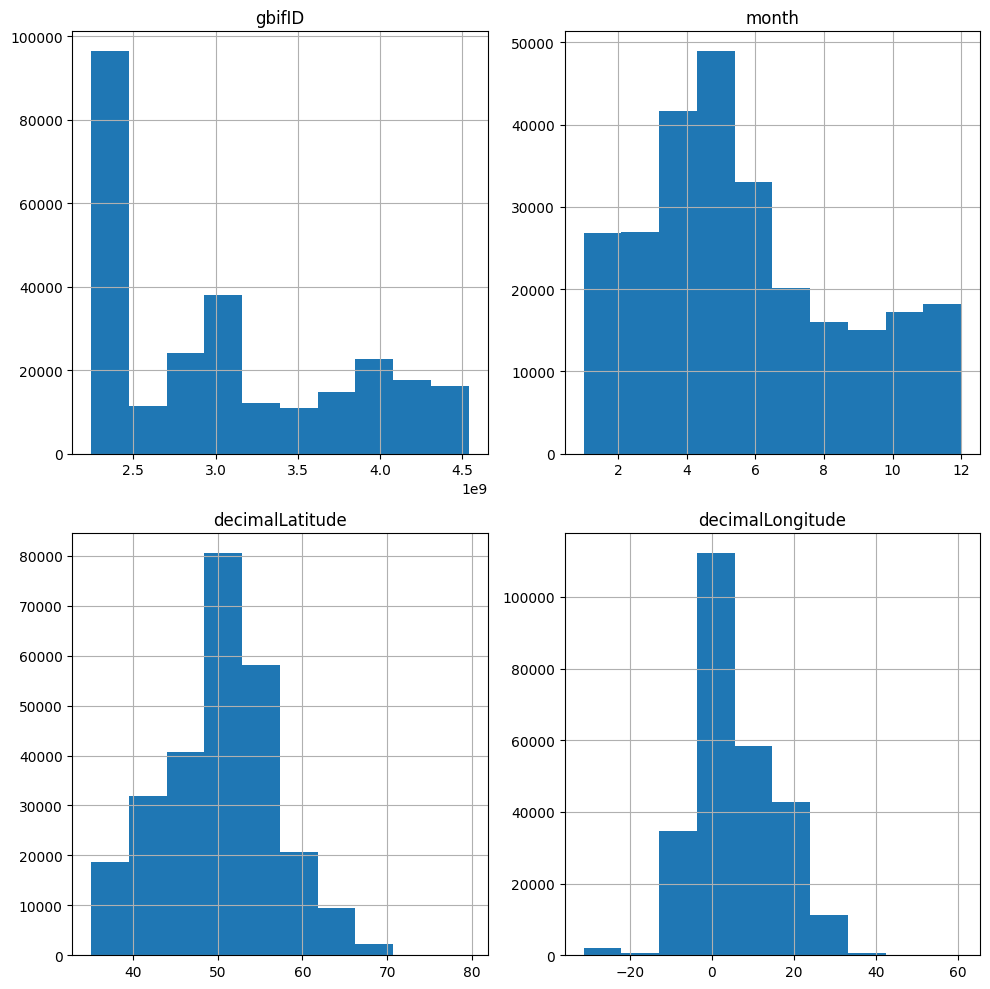

In [ ]:
df.hist(figsize=(10, 10))
plt.tight_layout()
plt.show()

**Data Analysis**: Identify patterns, trends, class imbalances, and outliers in the data. Additionally, explore the relationships between variables and identify any potential confounding variables that may impact the analysis.

In [ ]:
#Check the number of missing values
df.isnull().sum()
df.info()
df.head(5)
for col in ['basisOfRecord', 'sex', 'lifeStage', 'behavior', 'associatedTaxa', 'eventTime','continent', 'countryCode', 'verbatimElevation', 'mediaType']:
    print(col)
    print(df[col].unique())

<class 'pandas.core.frame.DataFrame'>
Index: 264260 entries, 0 to 716623
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   gbifID             264260 non-null  int64  
 1   references         264260 non-null  object 
 2   basisOfRecord      264260 non-null  object 
 3   catalogNumber      264260 non-null  object 
 4   sex                45249 non-null   object 
 5   lifeStage          51348 non-null   object 
 6   behavior           262573 non-null  object 
 7   associatedTaxa     96703 non-null   object 
 8   eventTime          248544 non-null  object 
 9   month              263718 non-null  float64
 10  continent          264260 non-null  object 
 11  countryCode        264260 non-null  object 
 12  verbatimElevation  264260 non-null  object 
 13  decimalLatitude    262700 non-null  float64
 14  decimalLongitude   262700 non-null  float64
 15  mediaType          264260 non-null  object 
 16  genus  

We can see that europe still has over 250k data entries in the dataset; compared to the around ~700k total entries in the dataset (from our last MS3 eda). Additionally, there are very few percentage of rows with null values which we are concerned with (position, species), signifying the data is higher quality from Europe when compared to the overall dataset. Since species is our response variable, we drop any rows where the species is not present. Additionally, we can see that about a quarter of the dataset has associated taxa, which indicates the presence of a significant amount of bakcground noise. We want our noise to be as clean as possible, and thus drop any row where the associated taxa column is not null. Our resulting dataset still has over 150k rows.

In [ ]:
df = df.dropna(subset=['species'])
df = df[df['associatedTaxa'].isna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159525 entries, 7 to 716620
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   gbifID             159525 non-null  int64  
 1   references         159525 non-null  object 
 2   basisOfRecord      159525 non-null  object 
 3   catalogNumber      159525 non-null  object 
 4   sex                21866 non-null   object 
 5   lifeStage          24742 non-null   object 
 6   behavior           158522 non-null  object 
 7   associatedTaxa     0 non-null       object 
 8   eventTime          147564 non-null  object 
 9   month              159281 non-null  float64
 10  continent          159525 non-null  object 
 11  countryCode        159525 non-null  object 
 12  verbatimElevation  159525 non-null  object 
 13  decimalLatitude    158573 non-null  float64
 14  decimalLongitude   158573 non-null  float64
 15  mediaType          159525 non-null  object 
 16  genus  

In [ ]:
#Find class imbalances
def plot_for_class_frequency(grouped, title):

  plt.boxplot(grouped,vert=False)
  plt.title(title)
  plt.xlabel("Number in Class")
  plt.show()


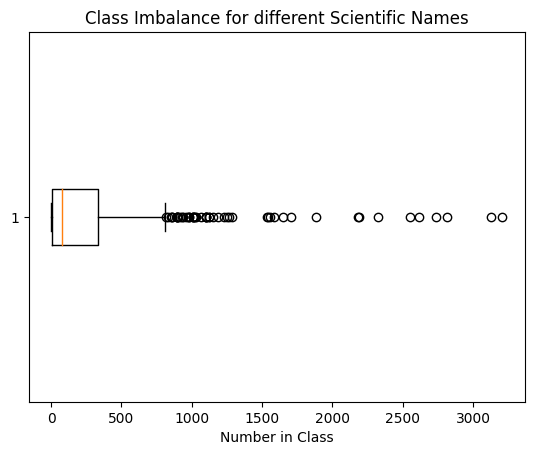

count     616.000000
mean      258.969156
std       437.774498
min         1.000000
25%         7.000000
50%        76.000000
75%       331.000000
max      3206.000000
dtype: float64

In [ ]:
#Check scientific name number of classes
class_frequencies_scientific = df.groupby(['species']).size()
plot_for_class_frequency(class_frequencies_scientific, "Class Imbalance for different Scientific Names")
class_frequencies_scientific.describe()


We can see that even considering our subset of data, the class imbalance is still bad, something we found in our original EDA from MS3. As a result, we are planning on taking the top 10 most frequently occurring species in the dataset and only predicting for this subset of data. Even with undersampling, we expect this to be enough audio data.

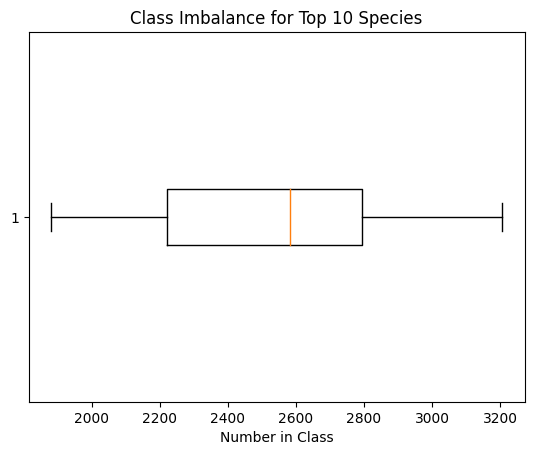

count      10.000000
mean     2562.200000
std       426.306306
min      1881.000000
25%      2222.750000
50%      2584.000000
75%      2794.250000
max      3206.000000
dtype: float64
species
Parus major                3206
Turdus merula              3126
Erithacus rubecula         2814
Phylloscopus collybita     2735
Loxia curvirostra          2617
Fringilla coelebs          2551
Strix aluco                2324
Sylvia atricapilla         2189
Turdus philomelos          2179
Troglodytes troglodytes    1881
dtype: int64


In [ ]:
#Now get top 50
NUM_SPECIES = 10
class_frequencies_scientific_top50 = df.groupby(['species']).size().nlargest(NUM_SPECIES)
plot_for_class_frequency(class_frequencies_scientific_top50, "Class Imbalance for Top 10 Species")
print(class_frequencies_scientific_top50.describe())
print(class_frequencies_scientific_top50)
species_to_keep = class_frequencies_scientific_top50.index


We can see the class imbalance restricting to the top 10 species is much more reasonable, and even if we were to undersample al the classes to the minimum frequency we would still have around 20k mp3s to process.

In [ ]:
df_filtered = df[df['species'].isin(species_to_keep)].drop(['associatedTaxa'], axis=1)

print(df_filtered.info())
print(df_filtered.head(5))



<class 'pandas.core.frame.DataFrame'>
Index: 25622 entries, 97 to 716611
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gbifID             25622 non-null  int64  
 1   references         25622 non-null  object 
 2   basisOfRecord      25622 non-null  object 
 3   catalogNumber      25622 non-null  object 
 4   sex                4666 non-null   object 
 5   lifeStage          4323 non-null   object 
 6   behavior           25456 non-null  object 
 7   eventTime          23467 non-null  object 
 8   month              25568 non-null  float64
 9   continent          25622 non-null  object 
 10  countryCode        25622 non-null  object 
 11  verbatimElevation  25622 non-null  object 
 12  decimalLatitude    25528 non-null  float64
 13  decimalLongitude   25528 non-null  float64
 14  mediaType          25622 non-null  object 
 15  genus              25622 non-null  object 
 16  species            25622 

<class 'pandas.core.frame.DataFrame'>
Index: 18810 entries, 117 to 716611
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gbifID             18810 non-null  int64  
 1   references         18810 non-null  object 
 2   basisOfRecord      18810 non-null  object 
 3   catalogNumber      18810 non-null  object 
 4   sex                3428 non-null   object 
 5   lifeStage          3216 non-null   object 
 6   behavior           18691 non-null  object 
 7   eventTime          17266 non-null  object 
 8   month              18768 non-null  float64
 9   continent          18810 non-null  object 
 10  countryCode        18810 non-null  object 
 11  verbatimElevation  18810 non-null  object 
 12  decimalLatitude    18741 non-null  float64
 13  decimalLongitude   18741 non-null  float64
 14  mediaType          18810 non-null  object 
 15  genus              18810 non-null  object 
 16  species            18810

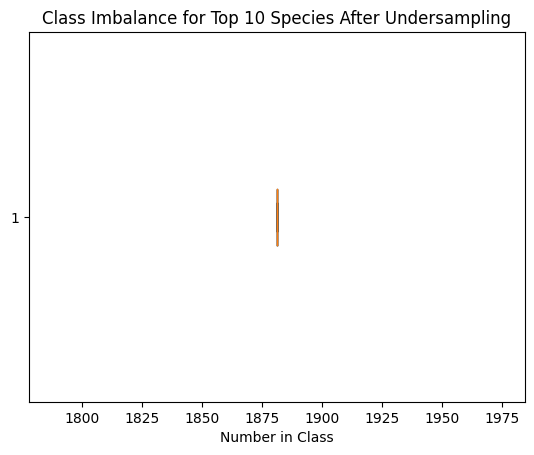

In [ ]:
np.random.seed(42)
NUM_TO_SAMPLE = np.min(class_frequencies_scientific_top50.values) #undersample number
df_undersampled = df_filtered
for species in species_to_keep:
  indices = df_undersampled[df_undersampled['species'] == species].index
  frequency = class_frequencies_scientific_top50[species]
  num_to_drop = frequency - NUM_TO_SAMPLE
  random_indices = np.random.choice(indices, num_to_drop, replace=False)
  df_undersampled = df_undersampled.drop(random_indices)
print(df_undersampled.info())
np.unique(df_undersampled.groupby(['species']).size().values)
plot_for_class_frequency(df_undersampled.groupby(['species']).size(), "Class Imbalance for Top 10 Species After Undersampling")



After undersampling, each type of species has the same frequency as expected.
One thing to note is that due to memory contraints in Colab, we re unable to undersample properly (i.e. undersample to the frequency of the smalled class), so we just settled with a hardcoded value of 10. Although this means our dataset will be very small for this milestone, we plan on undersampling properly before the final project submission.

As we can see, we will need to do some audio processing as well. Librosa luckily normalizes each audio file when we load it, so each is on the same sort of amplitude scale. However, from the spectrograms there are a few issues: the first is that each of these audio clips widely varies in their length. To combat this, we separate each clip into 5s chunks; the intution here is that often times, bird sounds are a repeated pattern, so having a big enough chunk to catch the entirety of the pattern would still let the neural net learn what audio maps to what bird. Now that we've split the audio to chunks, there is inevitably going to be some chunks with no meaningful audio. We can remove these chunks from our dataset. We detect silence by comparing the RMS of the audio chunk to a hand tuned threshold, and if it is lower than the threshold we deem it to be silent. If the last chunk in the audio is shorter, we remove it. this should give us a higher quality dataset for our model to train on.

In [ ]:
#Steps to do:
#1.Check the folder to see if a mp3 exists (can check oldmp3 newmp3 and mp3s)
#2.Drop any rows where the mp3 does not exist (print how many we are missing)
#3.Download all the mp3 audios and convert to wav
#4.Of the remaining, downsample accordingly
#
#from stack overflow
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled
#Create spectrogram for each and scale the imsage to between 0 and 1
def create_spectrograms(audio):
  mels = librosa.feature.melspectrogram(y=audio, sr=44100, n_fft = 448, win_length=224)
  mels = np.log(mels + 1e-9) # add small number to avoid log(0)

  # min-max scale to fit inside 8-bit range
  img = scale_minmax(mels, 0, 255).astype(np.uint8)
  img = np.flip(img, axis=0) # put low frequencies at the bottom in image
  return img
import math
df = None
del df
mp3_folder = '/content/drive/MyDrive/CS109b Final Project/mp3s'
oldmp3_folder = '/content/drive/MyDrive/CS109b Final Project/oldmp3s'
newmp3_folder = '/content/drive/MyDrive/CS109b Final Project/newmp3s'
png_folder = '/content/drive/MyDrive/CS109b Final Project/imgs'
chunk_time_sec = 5
X = []
y = []
num_processed = 0
THRESHOLD = 0.01
from PIL import Image
undersampled = df_undersampled['catalogNumber'].values
# im = Image.fromarray(arr)
# im.save("your_file.jpeg")
def rms_compute(input):
  return np.sqrt(np.average(np.square(input)))
for subdir, dirs, files in os.walk('/content/drive/MyDrive/CS109b Final Project/newmp3s_chunked'):
  for file in files:
      if (os.path.splitext(os.path.basename(file))[0] in undersampled):
        audio, sampling_rate = librosa.load(os.path.join(subdir, file), sr=44100)
        total_chunk_size = chunk_time_sec * sampling_rate #get size of chunks
        num_chunks = len(audio) // total_chunk_size
        if (num_chunks == 0):
          continue
        audio_to_split = audio[:num_chunks * total_chunk_size] #cut off last smaller chunk
        chunks = np.split(audio_to_split, num_chunks) #split on number of chunks for the audio
        counter = 0
        for index, chunk in enumerate(chunks):
          rms = rms_compute(chunk)
          if (rms >= THRESHOLD):
            base_name = os.path.splitext(os.path.basename(file))[0] + "_" + str(index) + ".png"
            spectrogram = create_spectrograms(chunk)
            im = Image.fromarray(spectrogram)
            im.save(os.path.join(png_folder, base_name))


/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
<ipython-input-32-54630cd4dc36>:42: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(os.path.join(subdir, file), sr=44100)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filt

We have done the chunking and audio preprocessing here, as described above.

In [ ]:
drive.mount('/content/drive', force_remount=True)
%cd /content/drive/MyDrive/CS109b Final Project
df_undersampled.to_csv("/content/drive/MyDrive/CS109b Final Project/datasets/undersampled_top_10.csv")
df_loaded = pd.read_csv("/content/drive/MyDrive/CS109b Final Project/datasets/undersampled_top_10.csv")


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Mounted at /content/drive
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-ed00a9917f40>", line 2, in <cell line: 2>
    get_ipython().run_line_magic('cd', '/content/drive/MyDrive/CS109b Final Project')
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py", line 342, in cd
    oldcwd = os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-55-ed00a9917f40>", line 2, in <cell line: 2>
    get_ipython().run_line_magic('cd', '/content/drive/MyDrive/CS109b Final Project')
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2418, in run_line_magic
    result = fn(*args, **kwargs)
  File "<decorator-gen-85>", line 2, in cd
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magic.py", line 187, in <lambda>
    call = lambda f, *a, **k: f(*a, **k)
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py", line 342, in cd
    oldcwd = os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/